<h2>Introduction</h2>

Here you will find a step by step guide to downloading, configuring, and running the Einstein Toolkit. You may use this tutorial on a workstation or laptop, or on a supported cluster. Configuring the Einstein Toolkit on an unsupported cluster is beyond the scope of this tutorial. If you find something that does not work, please feel free to email users@einsteintoolkit.org.

This tutorial is very basic and does not describe the internal workings of the Einstein Toolkit. For a more detailed introduction, please have a look a the [text](https://arxiv.org/abs/1305.5299) provided by Miguel Zilhão and Frank Löffler and the [one](https://arxiv.org/abs/2011.13314) by Nicholas Choustikov.

<h2>Prerequisites</h2>
When using the Einstein Toolkit on a laptop or workstation you will want a number of packages installed in order to download, compile and use the Einstein Toolkit components. If this is a machine which you control (i.e. you have root), you can install using one of the recipes that follow:

On Mac, please first 
- Install [Xcode](https://itunes.apple.com/us/app/xcode/id497799835) from the Apple [App Store](https://itunes.apple.com/us/app/xcode/id497799835). In *addition* agree to Xcode license and install the Xcode Command Line Tools in Terminal 
```bash
sudo xcodebuild -license
sudo xcode-select --install
```
- when using MacPorts
  - install MacPorts for your version of the Mac operating system, if you have not already installed it (https://www.macports.org/install.php). 
  - Next, please install the following packages, using the commands:
```bash
sudo port -N install pkgconfig gcc11 openmpi-gcc11 fftw-3 gsl jpeg zlib openssl zlib bash subversion ld64 hdf5 +fortran +gfortran
sudo port select mpi openmpi-gcc11-fortran
sudo port select gcc mp-gcc11
```
- when using HomeBrew
  - install HomeBrew for your version of the Mac operating system, if you have not already installed it (https://brew.sh/). 
  - Next, please install the following packages, using the commands:
```bash
brew install fftw gcc gsl hdf5 hwloc jpeg open-mpi openssl zlib pkg-config bash subversion
```

On Debian/Ubuntu/Mint use this command (the strange syntax is to suport all three of them):
```bash
$(sudo -l sudo) su -c 'apt-get update'
$(sudo -l sudo) su -c 'apt-get install -y subversion gcc git numactl libgsl-dev libpapi-dev python3 python-is-python3 python3-pip libhwloc-dev libudev-dev make libopenmpi-dev libhdf5-openmpi-dev libfftw3-dev libssl-dev liblapack-dev g++ curl gfortran patch pkg-config libhdf5-dev libjpeg-turbo?-dev'
```

On Fedora use this command:
```bash
sudo dnf install -y libjpeg-turbo-devel gcc git lapack-devel make subversion gcc-c++ which papi-devel perl python3 python3-pip hwloc-devel openmpi-devel hdf5-openmpi-devel openssl-devel libtool-ltdl-devel numactl-devel gcc-gfortran findutils hdf5-devel fftw-devel patch gsl-devel pkgconfig
module load mpi/openmpi-x86_64
```
You will have to repeat the `module load` command once in each new shell each time you would like to compile or run the code. You may have to log out and back in for the module command to become visible.

On Centos use this command:
```bash
su -c 'yum install -y epel-release'
su -c 'yum install --enablerepo=crb -y libjpeg-turbo-devel gcc git lapack-devel make subversion gcc-c++ which python3 python3-pip papi-devel hwloc-devel openmpi-devel openssl-devel libtool-ltdl-devel numactl-devel gcc-gfortran fftw-devel patch gsl-devel perl'
module load mpi/openmpi-x86_64
```
You will have to repeat the `module load` command once in each new shell each time you would like to compile or run the code. You may have to log out and back in for the module command to become visible.

On OpenSuse use this command:
```bash
sudo zypper install -y curl gcc git lapack-devel make subversion gcc-c++ which python3 python3-pip papi-devel hwloc-devel openmpi-devel libopenssl-devel libnuma-devel gcc-fortran hdf5-devel libfftw3-3 patch gsl-devel pkg-config
mpi-selector --set  $(mpi-selector --list | head -n1)
```
You will only have to execute the `mpi-selector` once, after that log out and back in to make the `mpirun` and `mpicc` commands visible without which Cactus will compile very slowly and fail to run.

On Windows 10/11 please install the Ubuntu Linux subsystem, then follow the instructions for a Ubuntu system. [These](https://docs.microsoft.com/en-us/windows/wsl/install) are Microsoft's official instructions on how to do so, [Ubuntu](https://ubuntu.com/wsl#install-ubuntu-on-wsl) provides an alternative version. You may also want to install native ssh client like [Putty](https://www.chiark.greenend.org.uk/~sgtatham/putty/) and an X11 server like [VcXsrv](https://sourceforge.net/projects/vcxsrv/), [XMing](https://sourceforge.net/projects/xming/) or an all-in-one solution for X11 server and ssh client like [MobaXterm](https://mobaxterm.mobatek.net/).

## Notebook setup
This notebook is intended to be used online on the Einstein Toolkit tutorial server, offline as a read-only document, as a jupyter notebook that you can download and also in your own docker container using `nds-org/jupyter-et`. To make all of these work some setting need to be tweaked, which we do in the next cell.

In [1]:
# this allows you to use "cd" in cells to change directories instead of requiring "%cd"
%automagic on
# override IPython's default %%bash to not buffer all output
from IPython.core.magic import register_cell_magic
@register_cell_magic
def bash(line, cell): get_ipython().system(cell)

# this (non-default package) keeps the end of shell output in view
try: import scrolldown
except ModuleNotFoundError: pass

# We are going to install kuibit, a Python package to post-process Cactus simulations.
# We will install kuibit inside the Cactus directory. The main reason for this is to
# have a make easier to uninstall kuibit (you can just remove the Cactus folder). 
import os, sys
os.environ["PYTHONUSERBASE"] = os.environ['HOME'] + "/Cactus/python"
sys.path.insert(1, f"{os.environ['PYTHONUSERBASE']}/lib/python{sys.version_info[0]}.{sys.version_info[1]}/site-packages")


Automagic is ON, % prefix IS NOT needed for line magics.


<IPython.core.display.Javascript object>

<b>Note:</b> By default, the cells in this notebook are Python commands. However, cells that start with <code>%%bash</code> are executed in a bash shell. If you wish to run these commands outside the notebook and in a bash shell, cut and paste only the part after the initial <code>%%bash</code>. 

## Optimized Download/Build Experience
Downloading the source code from github in a classroom setting, where lots of users are doing the same thing at the same time, can create network problems, and compiling the complete ET from scratch can take up to half an hour.

The next cell will create a complete pre-built ET checkout in your home directory, speeding up subsequent cells.  This step is optional, but should allow you to execute the notebook in less time.

**Note:** This will only work in the docker image or on the tutorial server.

In [2]:
%%bash
[ -r ~etuser/Cactus.tar.gz ] && ! [ -d ~/Cactus ] && tar -xzf ~etuser/Cactus.tar.gz -C ~/
[ -r ~etuser/simulations_tov_ET.tar.gz ] && ! [ -d ~/simulations/tov_ET ] && tar -xzf ~etuser/simulations_tov_ET.tar.gz -C ~/

<h2>Download</h2>

A script called GetComponents is used to fetch the components of the Einstein Toolkit. GetComponents serves as convenient wrapper around lower level tools like git and svn to download the codes that make up the Einstein toolkit from their individual repositories. You may download and make it executable as follows:

In [3]:
cd ~/

/home/jovyan


In [4]:
%%bash
curl -kLO https://raw.githubusercontent.com/gridaphobe/CRL/ET_2022_05/GetComponents
chmod a+x GetComponents

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   98k  100   98k    0     0   400k      0 --:--:-- --:--:-- --:--:--  400k


GetComponents accepts a thorn list as an argument. To check out the needed components:

In [5]:
%%bash
./GetComponents https://bitbucket.org/einsteintoolkit/manifest/raw/ET_2022_05/einsteintoolkit.th

Not updating existing components. If you want an update, re-run with --update
-----------------------------------------------------------------
  0 components checked out successfully.
  0 components updated successfully.

  Time Elapsed: 0 minutes, 1 seconds



In [6]:
cd ~/Cactus

/home/jovyan/Cactus


<h2>Configure and build</h2>

The recommended way to compile the Einstein Toolkit is to use the Simulation Factory ("SimFactory").
<h3>Configuring SimFactory for your machine</h3>

The ET depends on various libraries, and needs to interact with machine-specific queueing systems and MPI implementations. As such, it needs to be configured for a given machine. For this, it uses SimFactory. Generally, configuring SimFactory means providing an optionlist, for specifying library locations and build options, a submit script for using the batch queueing system, and a runscript, for specifying how Cactus should be run, e.g. which mpirun command to use.

In [7]:
%%bash
./simfactory/bin/sim setup-silent



Here we will define some necessary Simulation Factory defaults.


Determining local machine name: e4ed0a5d52b6
Creating machine e4ed0a5d52b6 from generic: machine e4ed0a5d52b6 [/home/jovyan/Cactus/repos/simfactory2/mdb/machines/e4ed0a5d52b6.ini] created successfully

--------------------SUMMARY--------------------:


[default]
user            = jovyan
email           = jovyan
allocation      = NO_ALLOCATION


------------------END SUMMARY------------------:

Contents successfully written to /home/jovyan/Cactus/repos/simfactory2/etc/defs.local.ini


After this step is complete you will find your machine's default setup under ./simfactory/mdb/machines/&lt;hostname &gt;.ini
You can edit some of these settings freely, such as "description", "basedir" etc. Some entry edits could result in simulation start-up warnings and/or errors such as "ppn" (processor-per-node meaning number of cores on your machine), "num-threads" (number of threads per core) so such edits must be done with some care.

<h2>Building the Einstein Toolkit</h2>

Assuming that SimFactory has been successfully set up on your machine, you should be able to build the Einstein Toolkit with the command below. The option "-j2" sets the make command that will be used by the script. The number used is the number of processes used when building. Even in parallel, this step may take a while, as it compiles all the thorns specified in thornlists/einsteintoolkit.th.

Note: Using too many processes to compile on the test machine may result in compiler failures, if the system runs out of memory.

In [8]:
%%bash
./simfactory/bin/sim build -j2 --thornlist thornlists/einsteintoolkit.th

Using configuration: sim
Updated thorn list for configuration sim
Building sim
Cactus - version: 4.11.0
Building configuration sim
Reconfiguring thorns
Reading ThornList...
Parsing configuration files...
   ADMAnalysis
           Requires:          CartGrid3D 
   ADMBase
           Requires:          CartGrid3D 
   ADMCoupling
   ADMDerivatives
           Requires thorns:   SummationByParts
   ADMMacros
           Provides:          ADMMacros 
   ADMMass
   AEILocalInterp
   AHFinder
           Requires:          CartGrid3D 
   AHFinderDirect
           Optional:          HDF5 
           Requires thorns:   SpaceMask
   BLAS
           Provides:          BLAS 
   Baikal
   BaikalVacuum
   Boundary
           Provides:          Boundary 
   CT_Analytic
           Requires:          GenericFD 
           Optional:          LoopControl 
   CT_MultiLevel
           Requires:          Carpet MPI 
   Cactus
           Optional:          MPI 
   CalcK
           Requires:          CartGrid3D 

Parsing interface files...
   ADMAnalysis
           Implements: ADMAnalysis
           Inherits:  ADMBase StaticConformal Grid ADMMacros 
           7 Public, 0 Protected, 0 Private variable groups
   ADMBase
           Implements: ADMBase
           Inherits:  grid 
           10 Public, 0 Protected, 0 Private variable groups
   ADMCoupling
           Implements: ADMCoupling
           0 Public, 0 Protected, 0 Private variable groups
   ADMDerivatives
           Implements: ADMDerivatives
           Inherits:  Coordinates ADMBase 
           6 Public, 0 Protected, 0 Private variable groups
   ADMMacros
           Implements: ADMMacros
           2 Public, 0 Protected, 0 Private variable groups
   ADMMass
           Implements: ADMMass
           Inherits:  ADMBase ADMMacros StaticConformal SpaceMask 
           0 Public, 0 Protected, 7 Private variable groups
   AEILocalInterp
           Implements: AEILocalInterp
           0 Public, 0 Protected, 0 Private variable groups
   AHFinde

           Implements: GRHydro
           Inherits:  ADMBase Boundary SpaceMask Tmunubase HydroBase 
           53 Public, 0 Protected, 39 Private variable groups
   GRHydro_InitData
           Implements: GRHydro_init_data
           Inherits:  GRHydro grid EOS_Omni 
           0 Public, 4 Protected, 2 Private variable groups
   GSL
           Implements: GSL
           0 Public, 0 Protected, 0 Private variable groups
   GaugeWave
           Implements: GaugeWave
           Inherits:  admbase Boundary GenericFD Grid 
           7 Public, 0 Protected, 0 Private variable groups
   GenericFD
           Implements: GenericFD
           0 Public, 0 Protected, 3 Private variable groups
   GiRaFFE
           Implements: GiRaFFE
           Inherits:  ADMBase Boundary SpaceMask Tmunubase HydroBase grid 
           9 Public, 0 Protected, 11 Private variable groups
   GiRaFFE_to_HydroBase
           Implements: GiRaFFE_to_HydroBase
           Inherits:  grid HydroBase ADMBase GiRaFFE 
          

           Implements: ModifiedSchwarzschildBL
           Inherits:  admbase Boundary GenericFD Grid 
           7 Public, 0 Protected, 0 Private variable groups
   Multipole
           Implements: multipole
           Inherits:  Grid 
           6 Public, 0 Protected, 0 Private variable groups
   NPScalars
           Implements: NPScalars
           Inherits:  ADMBase 
           0 Public, 0 Protected, 3 Private variable groups
   NPScalars_Proca
           Implements: NPScalars_Proca
           Inherits:  ADMBase ProcaBase 
           0 Public, 0 Protected, 9 Private variable groups
   NaNCatcher
           Implements: NaNCatcher
           0 Public, 0 Protected, 0 Private variable groups
   NaNChecker
           Implements: NaNChecker
           Inherits:  Reduce 
           0 Public, 0 Protected, 4 Private variable groups
   NewRad
           Implements: NewRad
           0 Public, 0 Protected, 0 Private variable groups
   Nice
           Implements: nice
           0 Public, 0 Pro

           Implements: SymBase
           0 Public, 0 Protected, 0 Private variable groups
   SystemStatistics
           Implements: SystemStatistics
           0 Public, 0 Protected, 4 Private variable groups
   SystemTopology
           Implements: SystemTopology
           0 Public, 0 Protected, 0 Private variable groups
   TATelliptic
           Implements: TATelliptic
           0 Public, 0 Protected, 0 Private variable groups
   TGRtensor
           Implements: TGRtensor
           0 Public, 0 Protected, 0 Private variable groups
   TOVSolver
           Implements: TOVSolver
           Inherits:  ADMBase HydroBase Constants StaticConformal 
           0 Public, 0 Protected, 0 Private variable groups
   TensorTypes
           Implements: TensorTypes
           0 Public, 0 Protected, 0 Private variable groups
   TerminationTrigger
           Implements: TerminationTrigger
           0 Public, 0 Protected, 3 Private variable groups
   TestArrays
           Implements: Arrays
      

Parsing parameter files...
   ADMAnalysis
           Shares: ADMBASE
          0 Global, 0 Restricted, 4 Private parameters
   ADMBase
          0 Global, 18 Restricted, 0 Private parameters
   ADMCoupling
          0 Global, 0 Restricted, 0 Private parameters
   ADMDerivatives
          0 Global, 0 Restricted, 6 Private parameters
   ADMMacros
          0 Global, 1 Restricted, 0 Private parameters
   ADMMass
          0 Global, 0 Restricted, 17 Private parameters
   AEILocalInterp
          0 Global, 0 Restricted, 1 Private parameters
   AHFinder
           Shares: ADMBASE ADMMACROS GRID IO SPACEMASK
          0 Global, 2 Restricted, 87 Private parameters
   AHFinderDirect
           Shares: ADMBASE GRID IO SPACEMASK SPHERICALSURFACE
          0 Global, 0 Restricted, 154 Private parameters
   BLAS
          0 Global, 0 Restricted, 0 Private parameters
   Baikal
           Shares: ADMBASE
          0 Global, 5 Restricted, 0 Private parameters
   BaikalVacuum
           Shares: ADMBASE


          0 Global, 59 Restricted, 2 Private parameters
   IllinoisGRMHD
           Shares: ADMBASE
          0 Global, 15 Restricted, 1 Private parameters
   InitBase
          0 Global, 1 Restricted, 0 Private parameters
   InterpToArray
          0 Global, 93 Restricted, 0 Private parameters
   Interpolate2
          0 Global, 0 Restricted, 11 Private parameters
   KerrSchild
           Shares: ADMBASE GENERICFD METHODOFLINES
          0 Global, 29 Restricted, 1 Private parameters
   LAPACK
          0 Global, 0 Restricted, 0 Private parameters
   LORENE
          0 Global, 0 Restricted, 0 Private parameters
   LeanBSSNMoL
           Shares: ADMBASE METHODOFLINES
          0 Global, 3 Restricted, 32 Private parameters
   LlamaWaveToy
           Shares: COORDINATES METHODOFLINES
          0 Global, 0 Restricted, 35 Private parameters
   LocalInterp
          0 Global, 0 Restricted, 0 Private parameters
   LocalInterp2
          0 Global, 0 Restricted, 0 Private parameters
   LocalRed

          0 Global, 15 Restricted, 9 Private parameters
   StaticConformal
           Shares: ADMBASE
          0 Global, 1 Restricted, 0 Private parameters
   SummationByParts
          0 Global, 23 Restricted, 0 Private parameters
   SymBase
          0 Global, 0 Restricted, 1 Private parameters
   SystemStatistics
          0 Global, 0 Restricted, 0 Private parameters
   SystemTopology
          0 Global, 0 Restricted, 2 Private parameters
   TATelliptic
          0 Global, 0 Restricted, 0 Private parameters
   TGRtensor
          0 Global, 0 Restricted, 0 Private parameters
   TOVSolver
           Shares: ADMBASE HYDROBASE STATICCONFORMAL
          0 Global, 0 Restricted, 27 Private parameters
   TensorTypes
          0 Global, 0 Restricted, 0 Private parameters
   TerminationTrigger
           Shares: IO
          0 Global, 0 Restricted, 10 Private parameters
   TestArrays
          0 Global, 0 Restricted, 20 Private parameters
   TestCarpetGridInfo
          0 Global, 0 Restricte

          145 schedule blocks.
   GRHydro_InitData
          35 schedule blocks.
   GSL
          0 schedule blocks.
   GaugeWave
          10 schedule blocks.
   GenericFD
          0 schedule blocks.
   GiRaFFE
          13 schedule blocks.
   GiRaFFE_to_HydroBase
          2 schedule blocks.
   GiRaFFEfood
          17 schedule blocks.
   GlobalDerivative
          2 schedule blocks.
   HDF5
          0 schedule blocks.
   HTTPD
          7 schedule blocks.
   HTTPDExtra
          1 schedule blocks.
   HelloWorld
          1 schedule blocks.
   HighOrderWaveTest
          0 schedule blocks.
   HydroBase
          22 schedule blocks.
   Hydro_Analysis
          17 schedule blocks.
   Hydro_InitExcision
          4 schedule blocks.
   Hydro_RNSID
          2 schedule blocks.
   IDAnalyticBH
          6 schedule blocks.
   IDAxiBrillBH
          2 schedule blocks.
   IDAxiOddBrillBH
          2 schedule blocks.
   IDBrillData
          3 schedule blocks.
   IDConstraintViolate
        

          48 schedule blocks.
   hwloc
          2 schedule blocks.
   libjpeg
          0 schedule blocks.
   particle_tracerET
          7 schedule blocks.
   pthreads
          0 schedule blocks.
   smallbPoynET
          1 schedule blocks.
   zlib
          0 schedule blocks.
Running any thorn-provided configuration scripts...

********************************************************************************
Running configuration script for thorn BLAS:
BLAS selected, but BLAS_DIR not set. Checking some places...
BLAS not found
Using bundled BLAS...
BLAS has already been built; doing nothing
Finished running configuration script for thorn BLAS.

********************************************************************************
Running configuration script for thorn FFTW3:
FFTW3 selected, but FFTW3_DIR not set. Checking some places...
Found FFTW3 in /usr
Finished running configuration script for thorn FFTW3.

******************************************************************************

Checking status of thorn RegridSyncTest
Checking status of thorn RotatingDBHIVP
Checking status of thorn SampleBoundary
Checking status of thorn SampleIO
Checking status of thorn Seed_Magnetic_Fields
Checking status of thorn Seed_Magnetic_Fields_BNS
Checking status of thorn SetMask_SphericalSurface
Checking status of thorn SlabTest
Checking status of thorn StaticConformal
Checking status of thorn SymBase
Checking status of thorn SystemStatistics
Checking status of thorn TerminationTrigger
Checking status of thorn TestArrays
Checking status of thorn TestComplex
Checking status of thorn TestCoordinates
Checking status of thorn TestFortranCrayPointers
Checking status of thorn TestFortranDependencies2
Checking status of thorn TestFpointerNULL
Checking status of thorn TestFreeF90
Checking status of thorn TestGlobalReduce
Checking status of thorn TestInclude1
Checking status of thorn TestInclude2
Checking status of thorn TestLocalInterp2
Checking status of thorn TestLocalReduce
Checking stat

Formaline: Optimising git repository (slow only the first time)...
Formaline: Done.
Formaline: (Formaline has finished updating the git repositories.
Formaline:  If the build process seems to hang, some other command
Formaline:  is still running, e.g. the final link stage.)
Done creating cactus_sim.
All done !
Building utilities for sim
Building utilities for sim
Copying AH2xdmf from /home/jovyan/Cactus/arrangements/EinsteinAnalysis/AHFinderDirect/src/util/AH2xdmf.py to /home/jovyan/Cactus/exe/sim
Compiling /home/jovyan/Cactus/arrangements/Carpet/CarpetIOASCII/src/util/carpet2xgraph.c
Compiling /home/jovyan/Cactus/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5toascii_slicer.cc
Compiling /home/jovyan/Cactus/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5tobinary_slicer.cc
Compiling /home/jovyan/Cactus/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5_slicer.cc
Compiling /home/jovyan/Cactus/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5_recombiner.cc
Compiling /home/jovyan/Cactus/arrangement

/home/jovyan/Cactus/arrangements/EinsteinInitialData/Hydro_RNSID/src/RNS.c:694:5: warning: ‘e_surface’ may be used uninitialized in this function [-Wmaybe-uninitialized]
  694 |     comp_values( s_gp, mu, r_ratio, e_surface, r_e, eos_type, log_e_tab,
      |     ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  695 |          log_n0_tab, n_tab, Omega, rho, gama, alpha, omega,
      |          ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  696 |             energy, pressure, enthalpy, velocity_sq, &Mass,
      |             ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  697 |             &Mass_0, &T, &W, &Omega_K, &R_e, rotation_type, Omega_diff,
      |             ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  698 |             &J);
      |             ~~~
Compiling /home/jovyan/Cactus/arrangements/EinsteinInitialData/Hydro_RNSID/src/equil.c
/home/jovyan/Cactus/arrangements/EinsteinInitialData/Hydro_RNSID/src/equil.c: In function ‘load_eos’

Compiling /home/jovyan/Cactus/arrangements/CactusPUGHIO/IOHDF5/src/util/hdf5_convert_from_carpetiohdf5.c
Copying mpirun from /usr/bin/mpirun to /home/jovyan/Cactus/exe/sim
Copying mpirun.mpich from /usr/bin/mpirun.mpich to /home/jovyan/Cactus/exe/sim
Compiling /home/jovyan/Cactus/arrangements/PITTNullCode/SphericalHarmonicRecon/src/util/ascii_output.c
Compiling /home/jovyan/Cactus/arrangements/PITTNullCode/SphericalHarmonicRecon/src/util/fftwfilter.c
Compiling /home/jovyan/Cactus/arrangements/PITTNullCode/SphericalHarmonicRecon/src/util/setmeta.c
Compiling /home/jovyan/Cactus/arrangements/PITTNullCode/SphericalHarmonicRecon/src/util/findlast.c
Compiling /home/jovyan/Cactus/arrangements/PITTNullCode/SphericalHarmonicRecon/src/util/printtime.c
Compiling /home/jovyan/Cactus/arrangements/PITTNullCode/SphericalHarmonicRecon/src/util/readmeta.c
Creating carpet2xgraph in /home/jovyan/Cactus/exe/sim from /home/jovyan/Cactus/configs/sim/build/CarpetIOASCII/carpet2xgraph.o
Creating hdf5toascii_s

<h2>Running a simple example</h2>

You can now run the Einstein Toolkit with a simple test parameter file.

In [9]:
%%bash
./simfactory/bin/sim create-run helloworld \
    --parfile arrangements/CactusExamples/HelloWorld/par/HelloWorld.par

Parameter file: /home/jovyan/Cactus/arrangements/CactusExamples/HelloWorld/par/HelloWorld.par
Skeleton Created
Job directory: "/home/jovyan/simulations/helloworld"
Executable: "/home/jovyan/Cactus/exe/cactus_sim"
Option list: "/home/jovyan/simulations/helloworld/SIMFACTORY/cfg/OptionList"
Submit script: "/home/jovyan/simulations/helloworld/SIMFACTORY/run/SubmitScript"
Run script: "/home/jovyan/simulations/helloworld/SIMFACTORY/run/RunScript"
Parameter file: "/home/jovyan/simulations/helloworld/SIMFACTORY/par/HelloWorld.par"
Simulation name: helloworld
Assigned restart id: 0 
Running simulation helloworld
+ set -e
+ cd /home/jovyan/simulations/helloworld/output-0000-active
+ echo Checking:
+ pwd
+ hostname
Preparing:
Checking:
/home/jovyan/simulations/helloworld/output-0000-active
e4ed0a5d52b6
+ date
Tue Aug  9 15:51:42 UTC 2022
+ echo Environment:
+ export CACTUS_NUM_PROCS=1
+ export CACTUS_NUM_THREADS=6
Environment:
+ export GMON_OUT_PREFIX=gmon.out
+ export OMP_NUM_THREADS=6
+ env
+ 

The above command will run the simulation naming it "helloworld" and display its log output to screen.

If you see <pre>INFO (HelloWorld): Hello World!</pre> anywhere in the above output, then congratulations, you have successfully downloaded, compiled and run the Einstein Toolkit! You may now want to try some of the other tutorials to explore some interesting physics examples.

<h2>Running single star simulation</h2>

What follows is the much more computationally intensive example of simulating a static TOV star. Just below this cell you can see the contents of a Cactus parameter file to simulate a single, spherical symmetric star using the Einstein Toolkit. The parameter file has been set up to run to completion in about 10 minutes, making it useful for a tutorial but too coarsely resolved to do science with it.

Run the cell to write its content to `par/tov_ET.par` so that it can be used for a short simulation.

In [10]:
%%bash
cat >par/tov_ET.par <<"#EOF"
# Example parameter file for a static TOV star. Everything is evolved, but
# because this is a solution to the GR and hydro equations, nothing changes
# much. What can be seen is the initial perturbation (due to numerical errors)
# ringing down (look at the density maximum), and later numerical errors
# governing the solution. Try higher resolutions to decrease this error.

# Some basic stuff
ActiveThorns = "Time MoL"
ActiveThorns = "Coordbase CartGrid3d Boundary StaticConformal"
ActiveThorns = "SymBase ADMBase TmunuBase HydroBase InitBase ADMCoupling ADMMacros"
ActiveThorns = "IOUtil"
ActiveThorns = "Formaline"
ActiveThorns = "SpaceMask CoordGauge Constants LocalReduce aeilocalinterp LoopControl"
ActiveThorns = "Carpet CarpetLib CarpetReduce CarpetRegrid2 CarpetInterp"
ActiveThorns = "CarpetIOASCII CarpetIOScalar CarpetIOHDF5 CarpetIOBasic"

# Finalize
Cactus::terminate           = "time"
Cactus::cctk_final_time     = 400 #800 # divide by ~203 to get ms

# Termination Trigger
ActiveThorns = "TerminationTrigger"
TerminationTrigger::max_walltime = 24          # hours
TerminationTrigger::on_remaining_walltime = 1  # minutes
TerminationTrigger::check_file_every = 512
TerminationTrigger::termination_file = "TerminationTrigger.txt"
TerminationTrigger::termination_from_file   = "yes"
TerminationTrigger::create_termination_file = "yes"

# grid parameters
Carpet::domain_from_coordbase = "yes"
CartGrid3D::type         = "coordbase"
CartGrid3D::domain       = "full"
CartGrid3D::avoid_origin = "no"
CoordBase::xmin =  0.0
CoordBase::ymin =  0.0
CoordBase::zmin =  0.0
CoordBase::xmax = 24.0
CoordBase::ymax = 24.0
CoordBase::zmax = 24.0
# Change these parameters to change resolution. The ?max settings above
# have to be multiples of these. 'dx' is the size of one cell in x-direction.
# Making this smaller means using higher resolution, because more points will
# be used to cover the same space.
CoordBase::dx   =   2.0
CoordBase::dy   =   2.0
CoordBase::dz   =   2.0

CarpetRegrid2::regrid_every =   0
CarpetRegrid2::num_centres  =   1
CarpetRegrid2::num_levels_1 =   2
CarpetRegrid2::radius_1[1]  = 12.0


CoordBase::boundary_size_x_lower        = 3
CoordBase::boundary_size_y_lower        = 3
CoordBase::boundary_size_z_lower        = 3
CoordBase::boundary_size_x_upper        = 3
CoordBase::boundary_size_y_upper        = 3
CoordBase::boundary_size_z_upper        = 3
CoordBase::boundary_shiftout_x_lower    = 1
CoordBase::boundary_shiftout_y_lower    = 1
CoordBase::boundary_shiftout_z_lower    = 1
CoordBase::boundary_shiftout_x_upper    = 0
CoordBase::boundary_shiftout_y_upper    = 0
CoordBase::boundary_shiftout_z_upper    = 0


ActiveThorns = "ReflectionSymmetry"

ReflectionSymmetry::reflection_x = "yes"
ReflectionSymmetry::reflection_y = "yes"
ReflectionSymmetry::reflection_z = "yes"
ReflectionSymmetry::avoid_origin_x = "no"
ReflectionSymmetry::avoid_origin_y = "no"
ReflectionSymmetry::avoid_origin_z = "no"

# storage and coupling
TmunuBase::stress_energy_storage = yes
TmunuBase::stress_energy_at_RHS  = yes
TmunuBase::timelevels            =  1
TmunuBase::prolongation_type     = none


HydroBase::timelevels            = 3

ADMMacros::spatial_order = 4

SpaceMask::use_mask      = "yes"

Carpet::enable_all_storage       = no
Carpet::use_buffer_zones         = "yes"

Carpet::poison_new_timelevels    = "yes"
Carpet::check_for_poison         = "no"

Carpet::init_3_timelevels        = no
Carpet::init_fill_timelevels     = "yes"

CarpetLib::poison_new_memory = "yes"
CarpetLib::poison_value      = 114

# system specific Carpet paramters
Carpet::max_refinement_levels    = 10
driver::ghost_size               = 3
Carpet::prolongation_order_space = 3
Carpet::prolongation_order_time  = 2

# Time integration
time::dtfac = 0.25

MoL::ODE_Method             = "rk4"
MoL::MoL_Intermediate_Steps = 4
MoL::MoL_Num_Scratch_Levels = 1

# check all physical variables for NaNs
#  This can save you computing time, so it's not a bad idea to do this
#  once in a whioe.
ActiveThorns = "NaNChecker"
NaNChecker::check_every = 16384
NaNChecker::action_if_found = "terminate" #"terminate", "just warn", "abort"
NaNChecker::check_vars = "ADMBase::metric ADMBase::lapse ADMBase::shift HydroBase::rho HydroBase::eps HydroBase::press HydroBase::vel"

# Hydro paramters

ActiveThorns = "EOS_Omni GRHydro"

HydroBase::evolution_method      = "GRHydro"

GRHydro::riemann_solver         = "Marquina"
GRHydro::GRHydro_eos_type       = "Polytype"
GRHydro::GRHydro_eos_table      = "2D_Polytrope"
GRHydro::recon_method           = "ppm"
GRHydro::GRHydro_stencil        = 3
GRHydro::bound                  = "none"
GRHydro::rho_abs_min            = 1.e-10
# Parameter controlling finite difference order of the Christoffel symbols in GRHydro
GRHydro::sources_spatial_order  = 4

# Curvature evolution parameters

ActiveThorns = "GenericFD NewRad"
ActiveThorns = "ML_BSSN ML_BSSN_Helper"
ADMBase::evolution_method        = "ML_BSSN"
ADMBase::lapse_evolution_method  = "ML_BSSN"
ADMBase::shift_evolution_method  = "ML_BSSN"
ADMBase::dtlapse_evolution_method= "ML_BSSN"
ADMBase::dtshift_evolution_method= "ML_BSSN"

ML_BSSN::timelevels = 3

ML_BSSN::harmonicN           = 1      # 1+log
ML_BSSN::harmonicF           = 2.0    # 1+log
ML_BSSN::evolveA             = 1
ML_BSSN::evolveB             = 1
# NOTE: The following parameters select geodesic slicing. This choice only enables you to evolve stationary spacetimes.
#       They will not allow you to simulate a collapsing TOV star.
ML_BSSN::ShiftGammaCoeff     = 0.0
ML_BSSN::AlphaDriver         = 0.0
ML_BSSN::BetaDriver          = 0.0
ML_BSSN::advectLapse         = 0
ML_BSSN::advectShift         = 0
ML_BSSN::MinimumLapse        = 1.0e-8

ML_BSSN::my_initial_boundary_condition = "extrapolate-gammas"
ML_BSSN::my_rhs_boundary_condition     = "NewRad"

# Some dissipation to get rid of high-frequency noise
ActiveThorns = "SphericalSurface Dissipation"
Dissipation::verbose   = "no"
Dissipation::epsdis   = 0.01
Dissipation::vars = "
        ML_BSSN::ML_log_confac
        ML_BSSN::ML_metric
        ML_BSSN::ML_curv
        ML_BSSN::ML_trace_curv
        ML_BSSN::ML_Gamma
        ML_BSSN::ML_lapse
        ML_BSSN::ML_shift
"


# init parameters
InitBase::initial_data_setup_method = "init_some_levels"

# Use TOV as initial data
ActiveThorns = "TOVSolver"

HydroBase::initial_hydro         = "tov"
ADMBase::initial_data            = "tov"
ADMBase::initial_lapse           = "tov"
ADMBase::initial_shift           = "tov"
ADMBase::initial_dtlapse         = "zero"
ADMBase::initial_dtshift         = "zero"

# Parameters for initial star
TOVSolver::TOV_Rho_Central[0] = 1.28e-3
TOVSolver::TOV_Gamma          = 2
TOVSolver::TOV_K              = 100

# Set equation of state for evolution
EOS_Omni::poly_gamma                   = 2
EOS_Omni::poly_k                       = 100
EOS_Omni::gl_gamma                     = 2
EOS_Omni::gl_k                         = 100


# I/O

# Use (create if necessary) an output directory named like the
# parameter file (minus the .par)
IO::out_dir             = ${parfile}

# Write one file overall per output (variable/group)
# In production runs, comment this or set to "proc" to get one file
# per MPI process
IO::out_mode            = "onefile"

# Some screen output
IOBasic::outInfo_every = 512
IOBasic::outInfo_vars  = "Carpet::physical_time_per_hour HydroBase::rho{reductions='maximum'}"

# Scalar output
IOScalar::outScalar_every    = 512
IOScalar::one_file_per_group = "yes"
IOScalar::outScalar_reductions = "norm1 norm2 norm_inf sum maximum minimum"
IOScalar::outScalar_vars     = "
 HydroBase::rho{reductions='maximum'}
 HydroBase::press{reductions='maximum'}
 HydroBase::eps{reductions='minimum maximum'}
 HydroBase::vel{reductions='minimum maximum'}
 HydroBase::w_lorentz{reductions='minimum maximum'}
 ADMBase::lapse{reductions='minimum maximum'}
 ADMBase::shift{reductions='minimum maximum'}
 ML_BSSN::ML_Ham{reductions='norm1 norm2 maximum minimum norm_inf'}
 ML_BSSN::ML_mom{reductions='norm1 norm2 maximum minimum norm_inf'}
 GRHydro::dens{reductions='minimum maximum sum'}
 Carpet::timing{reductions='average'}
"

# 1D ASCII output. Disable for production runs!
IOASCII::out1D_every        = 2048
IOASCII::one_file_per_group = yes
IOASCII::output_symmetry_points = no
IOASCII::out1D_vars         = "
 HydroBase::rho
 HydroBase::press
 HydroBase::eps
 HydroBase::vel
 ADMBase::lapse
 ADMBase::metric
 ADMBase::curv
 ML_BSSN::ML_Ham
 ML_BSSN::ML_mom
"

# 2D HDF5 output
CarpetIOHDF5::output_buffer_points = "no"

CarpetIOHDF5::out2D_every = 2048
CarpetIOHDF5::out2D_vars = "
 HydroBase::rho
 HydroBase::eps
 HydroBase::vel
 HydroBase::w_lorentz
 ADMBase::lapse
 ADMBase::shift
 ADMBase::metric
 ML_BSSN::ML_Ham
 ML_BSSN::ML_mom
 "
#EOF

Simfactory maintain the concept of a self-contained "simulation" which is identified by a name and stores its parameter file, executable and other related files. Once a simulation has been created individual simulation segments can be submitted using the stored executable and parameter file.

In [11]:
%%bash
# create simulation directory structure
./simfactory/bin/sim create tov_ET_short --configuration sim --parfile=par/tov_ET.par

Parameter file: /home/jovyan/Cactus/par/tov_ET.par
Skeleton Created
Job directory: "/home/jovyan/simulations/tov_ET_short"
Executable: "/home/jovyan/Cactus/exe/cactus_sim"
Option list: "/home/jovyan/simulations/tov_ET_short/SIMFACTORY/cfg/OptionList"
Submit script: "/home/jovyan/simulations/tov_ET_short/SIMFACTORY/run/SubmitScript"
Run script: "/home/jovyan/simulations/tov_ET_short/SIMFACTORY/run/RunScript"
Parameter file: "/home/jovyan/simulations/tov_ET_short/SIMFACTORY/par/tov_ET.par"


The `create` command sets up the simulation directory skeleton. It copies the executable, parameter file as well as Simfactory's queuing scripts.

In [12]:
%%bash
# start simulation segment
./simfactory/bin/sim submit tov_ET_short --cores=2 --num-threads=1 --walltime=0:02:00

Assigned restart id: 0 
Executing submit command: exec nohup /home/jovyan/simulations/tov_ET_short/output-0000/SIMFACTORY/SubmitScript < /dev/null > /home/jovyan/simulations/tov_ET_short/output-0000/tov_ET_short.out 2> /home/jovyan/simulations/tov_ET_short/output-0000/tov_ET_short.err & echo $!
Submit finished, job id is 7277


The `submit` command submitted a new segment for the simulation `tov_ET_short` to the queueing system to run in the background asking for a maximum runtime of 20 minutes, using a total of 2 compute cores and using 1 thread per MPI ranks. On your laptop it will start right away, on a cluster the queuing system will wait until a sufficient number of nodes is able to start your simulation.

You can check the status of the simulation with the command below. You can run this command repeatedly until the job shows <pre>[ACTIVE (FINISHED)...</pre> as its state. Prior to that, it may show up as QUEUED or RUNNING.

In [13]:
%%bash
./simfactory/bin/sim list-simulations tov_ET_short

   tov_ET_short            [ACTIVE (FINISHED), restart 0000, job id 7277]


 To watch a simulation's log output use the `show-output` command of simfactory. **Interrupt the kernel** (or press `CTRL-C` if copying & pasting these commands to a terminal) if you wish to stop watching.

In [14]:
%%bash
# watch log output, following along as new output is produced
./simfactory/bin/sim show-output --follow tov_ET_short

Simulation name: tov_ET_short
The job's Formaline output is:
(file does not exist)
The job's stdout is:

The job's stderr is:



You can leave out the `--follow` option if you would like to see all output up to this point.

## Managing submitted simulations

Since the `submit` command was used to start the  simulation, it is running in the background and you have to use simfactory commands to interact with it. The next cell shows how to list simulations.

**Remember** that you have to interrupt the kernel to stop `show-output` and be able to execute the cells below.

In [15]:
%%bash
./simfactory/bin/sim list-simulations

   helloworld              [ACTIVE (FINISHED), restart 0000, job id -1]
   tov_ET                  [ACTIVE (FINISHED), restart 0000, job id 7275]
   tov_ET_short            [ACTIVE (FINISHED), restart 0000, job id 7277]


Simfactory offers a `stop` command to abort a running simulation. The next cell has the command intentionally commented out to prevent accidental stopping of your very first simulation.

In [16]:
%%bash
#./simfactory/bin/sim stop tov_ET_short

after this the simulation changes to the "FINISHED" state indicating it is no longer running.

Simulations that are no longer needed are removed using the `purge` command. The next cell has the command intentionally commented out to prevent accidental removing of your very first simulation.

In [17]:
%%bash
#./simfactory/bin/sim purge tov_ET_short

Simfactory creates all output for a simulation in a set of output directories, one for each restart from a checkpoint. You can find out its location using `get-output-dir`.

In [18]:
%%bash
./simfactory/bin/sim get-output-dir tov_ET_short

/home/jovyan/simulations/tov_ET_short/output-0000


<h2>Plotting the Output</h2>

The simplest way to analyze a simulation is using [kuibit](https://sbozzolo.github.io/kuibit/). a Python package for post-processing and visualization. `kuibit` is part of the Einstein Toolkit, but has to be installed separately. You can install `kuibit` with `pip3`. This will take care of all the required dependencies.

In [19]:
%%bash
# We install kuibit inside the Cactus folder so that if you wish to
# remove kuibit you can simply remove the folder. You can ignore the
# following line if you want to install kuibit along your other python
# packages.
export PYTHONUSERBASE="$HOME/Cactus/python"
pip3 install -U --user kuibit==1.3.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.4/371.4 kB 2.1 MB/s eta 0:00:0000:01


`kuibit` is a Python library: you can use it in Python scripts/notebooks to inspect and post-process your simulations. `kuibit` has rich [documentation](https://sbozzolo.github.io/kuibit) and tutorials to get use the package. Here, we are going to show only a few features.

The Einstein Toolkit comes with several [kuibit examples](https://sbozzolo.github.io/kuibit/#examples) that are ready to be used. The examples are available in the `utils/Analysis/kuibit/examples` folder. Most of these codes are command-line scripts that produce plots. 

For example, two common plots are for timeseries and for grid variables. For those, we can use the `plot_timeseries.py` and `plot_grid_var.py` codes:

In [20]:
%%bash
# Plot a timeseries with the maximum of the density
./utils/Analysis/kuibit/examples/bins/plot_timeseries.py \
--datadir $HOME/simulations/tov_ET --variable "rho" --reduction "maximum" \
--outdir $HOME/simulations/tov_ET

# Plot a 2D slice of the rest-mass density (which does not support reflection 
# symmetry, see below). 
#`-x0` and `-x1` define the region we want to plot: they coordinates of the 
# lower left and top right corners. 
#When not specified, the latest available iteration is plotted. 
./utils/Analysis/kuibit/examples/bins/plot_grid_var.py \
--datadir $HOME/simulations/tov_ET --variable "rho" -x0 0 0 -x1 10 10 \
--outdir  $HOME/simulations/tov_ET --logscale --multilinear-interpolate \
--colorbar

The outputs are two images named `rho_maximum.png` and `rho_xy.png` saved in the folder of the simulation.
Let's have a look at them

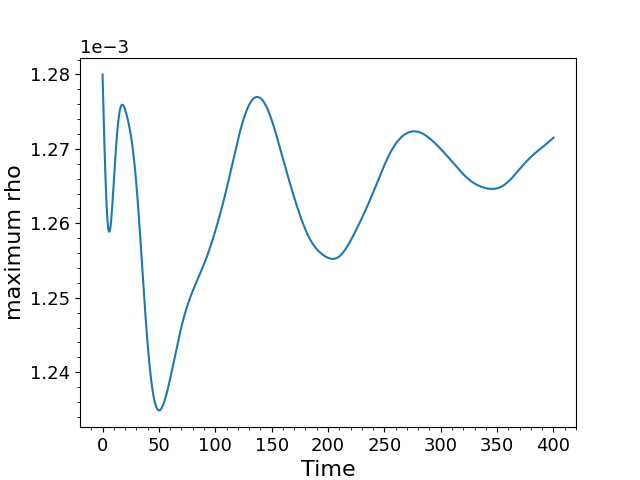

In [21]:
from IPython.display import Image

# datadir is the top-level directory that contains that data for
# a given simulation.
datadir = os.environ["HOME"]+"/simulations/tov_ET"
Image(filename=os.path.join(datadir, "rho_maximum.png"))

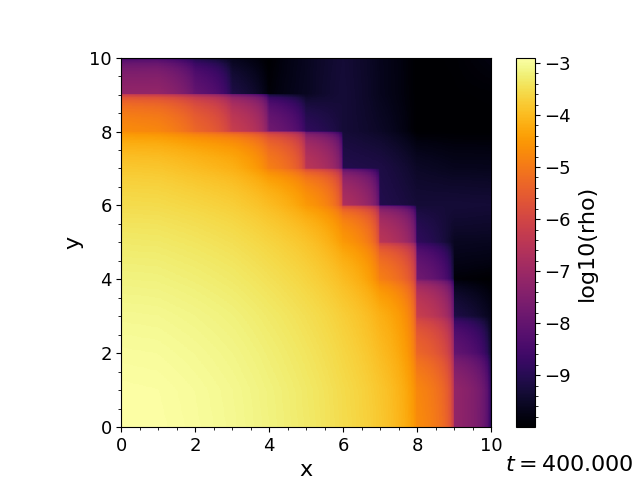

In [22]:
Image(filename=os.path.join(datadir, "rho_xy.png"))

While the examples are handy and have lots of options, often we want full control. For that, we use `kuibit` as a library. Let's see how we can make plots similar to the ones we generated with the examples. First, we import what we need:

In [23]:
# This cell enables inline plotting in the notebook
%matplotlib inline

import matplotlib.pyplot as plt
from kuibit.simdir import SimDir
import kuibit.visualize_matplotlib as viz

The main interface to simulation data in `kuibit` is the `SimDir`. It contains all the information that `kuibit` can extract from the output. `SimDir` takes as input the top level folder of the output. 

In [24]:
sim = SimDir(datadir)
# This will print a list with all the data available
print(sim)

Indexed 135 files and 3 subdirectories
Folder /home/jovyan/simulations/tov_ET
Available scalar timeseries:
[]

Available minimum timeseries:
['alp', 'betax', 'betay', 'betaz', 'dens', 'eps', 'vel[0]', 'vel[1]', 'vel[2]', 'w_lorentz', 'H', 'M1', 'M2', 'M3']

Available maximum timeseries:
['alp', 'betax', 'betay', 'betaz', 'dens', 'rho', 'press', 'eps', 'vel[0]', 'vel[1]', 'vel[2]', 'w_lorentz', 'H', 'M1', 'M2', 'M3']

Available norm1 timeseries:
['H', 'M1', 'M2', 'M3']

Available norm2 timeseries:
['H', 'M1', 'M2', 'M3']

Available average timeseries:
['physical_time_per_hour', 'current_physical_time_per_hour', 'time_total', 'time_evolution', 'time_computing', 'time_communicating', 'time_io', 'evolution_steps_count', 'local_grid_points_per_second', 'total_grid_points_per_second', 'local_grid_point_updates_count', 'total_grid_point_updates_count', 'local_interior_points_per_second', 'total_interior_points_per_second', 'local_interior_point_updates_count', 'total_interior_point_updates_co

Let's plot the maximum pressure and compare it with the pressure as computed from the maximum density.

Max difference 1.952e-18


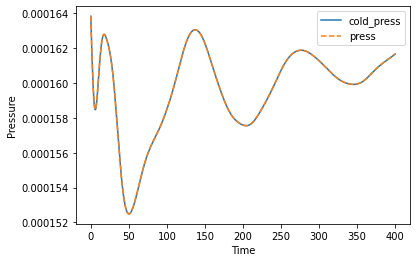

In [25]:
rho = sim.timeseries.maximum['rho']
press = sim.timeseries.maximum['press']

# Polytropic constants
K, Gamma = 100, 2

# Timeseries in kuibit support all the algebraic operations
cold_press = K * rho**Gamma

plt.ylabel("Pressure")
plt.xlabel("Time")
plt.plot(cold_press, label="cold_press")
plt.plot(press, label="press", ls="dashed")
plt.legend()

max_diff = abs(press - cold_press).max()

print(f"Max difference {max_diff:.3e}")

Let's plot an equatorial slice of the rest-mass density at the initial iteration.

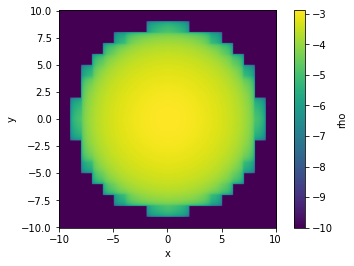

In [26]:
iteration_number = 0
rho_xy = sim.gridfunctions.xy["rho"][iteration_number]

# We cannot plot rho_xy directly because it contains all
# the information for the various refinement levels. 
# We need to resample the data onto a uniform grid.

# shape is the resolution at which we resample
# x0, x1 are the bottom left and top right coordiantes
# that we want to consider

# Here we choose x0=[0,0] because we have reflection 
# symmetry

# resample=True activates multilinear resampling

rho_xy_unif = rho_xy.to_UniformGridData(shape=[100, 100], 
                                        x0=[0,0],
                                        x1=[10, 10],
                                        resample=True)

# Undo reflection symmetry on the x axis
rho_xy_unif.reflection_symmetry_undo(dimension=0)
# Undo reflection symmetry on the y axis
rho_xy_unif.reflection_symmetry_undo(dimension=1)

viz.plot_color(rho_xy_unif,
               logscale=True,
               colorbar=True,
               label="rho",
               xlabel="x",
               ylabel="y",
              )

The image is pixelated because the resolution of our simulation is very low.

Finally, we can compare our data with some reference values.

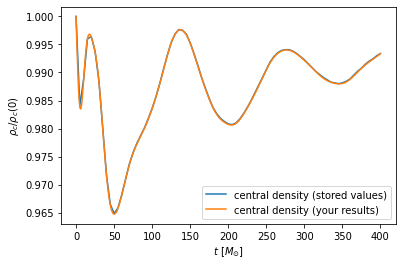

In [27]:
# this cell shows the expected plot using previously stored data
import numpy as np

# reconstruct plot data from saved strings
(quant_diff_s, minval, maxval, delta_t) = \
  ("ff8baee2e5d2ac70320c0007182c404f5b656f7b8897a8bbcddde8eeede8ddcfc0b0a29589817b777473757a8189929ca6b0bac4cbd0d3d4d4d2cfcbc7c2bdb8b4b0adaaa9a8a9abaeb3b8bcc1c5c8cccf",
   1.235e-03, 1.280e-03, 5.000e+00)
quant_diff = np.array(bytearray.fromhex(quant_diff_s))
rec_vals = quant_diff / 255. * (maxval- minval) + minval
rec_time = np.arange(0,len(quant_diff)) * delta_t

# plot them, including your results if you have them
plt.plot(rec_time, rec_vals/rec_vals[0],
         label="central density (stored values)")
try: plt.plot(rho/rho(0), label="central density (your results)")
except: pass
plt.xlabel(r'$t$ [$M_{\odot}$]');
plt.ylabel(r'$\rho_c / \rho_c(0)$');
plt.legend(loc='lower right');

Running the cell above will produce a plot of the expected results as well as your own results.
![Central density(stored value)](https://github.com/nds-org/jupyter-et/raw/master/data/tov_ET.png)

In [28]:
# create small dataset to show what plot should look like
def sparsify(lin_data, sparsity):
    # drop unwanted datapoint
    sparse_data = lin_data[::sparsity,:]
    
    # compute min, max of dataset then difference to minimum and quantize to 8 bit precisison
    minval = np.amin(sparse_data[:,2])
    maxval = np.amax(sparse_data[:,2])
    print("minval:",minval)
    print("maxval:",maxval)
    diff = sparse_data[:,2] - minval
    quant_diff = np.minimum(np.maximum(np.round(diff / (maxval - minval) * 255.5), 0), 255).astype('int')

    # timesteps are equidistant and start at 0 so we only need the stepsize
    delta_t = sparse_data[1,1] - sparse_data[0,1]

    # string rep of 8bit differences
    quant_diff_s = ""
    for i in quant_diff: quant_diff_s += "%02x" % i
    
    print ('"%s", %.3e, %.3e, %.3e' % (quant_diff_s, minval, maxval, delta_t))

# create a low fidelity representation of every 10th datapoint and output all data a string
sparsify(np.array([rho.t,rho.x,rho.y]).transpose(), 10)    

minval: 0.00123486424895186
maxval: 0.00127999999244924
"ff8baee2e5d2ac70320c0007182c404f5b656f7b8897a8bbcddde8eeede8ddcfc0b0a29589817b777473757a8189929ca6b0bac4cbd0d3d4d4d2cfcbc7c2bdb8b4b0adaaa9a8a9abaeb3b8bcc1c5c8cccf", 1.235e-03, 1.280e-03, 5.000e+00


In [78]:
%%bash
cat >par/headon_ET.par <<"#EOF"
# Example parameter file for a head-on collision. Everything is evolved, but
# because this is a solution to the GR and hydro equations, nothing changes
# much. What can be seen is the initial perturbation (due to numerical errors)
# ringing down (look at the density maximum), and later numerical errors
# governing the solution. Try higher resolutions to decrease this error.

# Some basic stuff
ActiveThorns = "Time MoL"
ActiveThorns = "Coordbase CartGrid3d Boundary StaticConformal"
ActiveThorns = "SymBase ADMBase TmunuBase HydroBase InitBase ADMCoupling ADMMacros"
ActiveThorns = "IOUtil"
ActiveThorns = "Formaline"
ActiveThorns = "SpaceMask CoordGauge Constants LocalReduce aeilocalinterp LoopControl"
ActiveThorns = "Carpet CarpetLib CarpetReduce CarpetRegrid2 CarpetInterp"
ActiveThorns = "CarpetIOASCII CarpetIOScalar CarpetIOHDF5 CarpetIOBasic"

# Finalize
Cactus::terminate           = "time"
Cactus::cctk_final_time     = 400 #800 # divide by ~203 to get ms

# Termination Trigger
ActiveThorns = "TerminationTrigger"
TerminationTrigger::max_walltime = 24          # hours
TerminationTrigger::on_remaining_walltime = 1  # minutes
TerminationTrigger::check_file_every = 512
TerminationTrigger::termination_file = "TerminationTrigger.txt"
TerminationTrigger::termination_from_file   = "yes"
TerminationTrigger::create_termination_file = "yes"

# grid parameters
Carpet::domain_from_coordbase = "yes"
CartGrid3D::type         = "coordbase"
CartGrid3D::domain       = "full"
CartGrid3D::avoid_origin = "no"
CoordBase::xmin =  0.0
CoordBase::ymin =  0.0
CoordBase::zmin =  0.0
# CHANGE
CoordBase::xmax = 48.0 # make longer
CoordBase::ymax = 24.0
CoordBase::zmax = 24.0
# Change these parameters to change resolution. The ?max settings above
# have to be multiples of these. 'dx' is the size of one cell in x-direction.
# Making this smaller means using higher resolution, because more points will
# be used to cover the same space.
# CHANGE
CoordBase::dx   =   1.0 # double resolution, 8x more memory, 2x number of steps -> 16x resources
CoordBase::dy   =   1.0
CoordBase::dz   =   1.0

CarpetRegrid2::regrid_every =   0
CarpetRegrid2::num_centres  =   1
CarpetRegrid2::num_levels_1 =   2
CarpetRegrid2::radius_1[1]  = 12.0
# CHANGE
CarpetRegrid2::position_x_1 = 18.0 # move center to new center of star


CoordBase::boundary_size_x_lower        = 3
CoordBase::boundary_size_y_lower        = 3
CoordBase::boundary_size_z_lower        = 3
CoordBase::boundary_size_x_upper        = 3
CoordBase::boundary_size_y_upper        = 3
CoordBase::boundary_size_z_upper        = 3
CoordBase::boundary_shiftout_x_lower    = 1
CoordBase::boundary_shiftout_y_lower    = 1
CoordBase::boundary_shiftout_z_lower    = 1
CoordBase::boundary_shiftout_x_upper    = 0
CoordBase::boundary_shiftout_y_upper    = 0
CoordBase::boundary_shiftout_z_upper    = 0


ActiveThorns = "ReflectionSymmetry"

ReflectionSymmetry::reflection_x = "yes"
ReflectionSymmetry::reflection_y = "yes"
ReflectionSymmetry::reflection_z = "yes"
ReflectionSymmetry::avoid_origin_x = "no"
ReflectionSymmetry::avoid_origin_y = "no"
ReflectionSymmetry::avoid_origin_z = "no"

# storage and coupling
TmunuBase::stress_energy_storage = yes
TmunuBase::stress_energy_at_RHS  = yes
TmunuBase::timelevels            =  1
TmunuBase::prolongation_type     = none


HydroBase::timelevels            = 3

ADMMacros::spatial_order = 4

SpaceMask::use_mask      = "yes"

Carpet::enable_all_storage       = no
Carpet::use_buffer_zones         = "yes"

Carpet::poison_new_timelevels    = "yes"
Carpet::check_for_poison         = "no"

Carpet::init_3_timelevels        = no
Carpet::init_fill_timelevels     = "yes"

CarpetLib::poison_new_memory = "yes"
CarpetLib::poison_value      = 114

# system specific Carpet paramters
Carpet::max_refinement_levels    = 10
driver::ghost_size               = 3
Carpet::prolongation_order_space = 3
Carpet::prolongation_order_time  = 2

# Time integration
time::dtfac = 0.25

MoL::ODE_Method             = "rk4"
MoL::MoL_Intermediate_Steps = 4
MoL::MoL_Num_Scratch_Levels = 1

# check all physical variables for NaNs
#  This can save you computing time, so it's not a bad idea to do this
#  once in a whioe.
ActiveThorns = "NaNChecker"
NaNChecker::check_every = 16384
NaNChecker::action_if_found = "terminate" #"terminate", "just warn", "abort"
NaNChecker::check_vars = "ADMBase::metric ADMBase::lapse ADMBase::shift HydroBase::rho HydroBase::eps HydroBase::press HydroBase::vel"

# Hydro paramters

ActiveThorns = "EOS_Omni GRHydro"

HydroBase::evolution_method      = "GRHydro"

GRHydro::riemann_solver         = "Marquina"
GRHydro::GRHydro_eos_type       = "Polytype"
GRHydro::GRHydro_eos_table      = "2D_Polytrope"
GRHydro::recon_method           = "ppm"
GRHydro::GRHydro_stencil        = 3
GRHydro::bound                  = "none"
GRHydro::rho_abs_min            = 1.e-10
# Parameter controlling finite difference order of the Christoffel symbols in GRHydro
GRHydro::sources_spatial_order  = 4

# Curvature evolution parameters

ActiveThorns = "GenericFD NewRad"
ActiveThorns = "ML_BSSN ML_BSSN_Helper"
ADMBase::evolution_method        = "ML_BSSN"
ADMBase::lapse_evolution_method  = "ML_BSSN"
ADMBase::shift_evolution_method  = "ML_BSSN"
ADMBase::dtlapse_evolution_method= "ML_BSSN"
ADMBase::dtshift_evolution_method= "ML_BSSN"

ML_BSSN::timelevels = 3

ML_BSSN::harmonicN           = 1      # 1+log
ML_BSSN::harmonicF           = 2.0    # 1+log
ML_BSSN::evolveA             = 1
ML_BSSN::evolveB             = 1
# NOTE: The following parameters select geodesic slicing. This choice only enables you to evolve stationary spacetimes.
#       They will not allow you to simulate a collapsing TOV star.
ML_BSSN::ShiftGammaCoeff     = 0.0
ML_BSSN::AlphaDriver         = 0.0
ML_BSSN::BetaDriver          = 0.0
ML_BSSN::advectLapse         = 0
ML_BSSN::advectShift         = 0
ML_BSSN::MinimumLapse        = 1.0e-8

ML_BSSN::my_initial_boundary_condition = "extrapolate-gammas"
ML_BSSN::my_rhs_boundary_condition     = "NewRad"

# Some dissipation to get rid of high-frequency noise
ActiveThorns = "SphericalSurface Dissipation"
Dissipation::verbose   = "no"
Dissipation::epsdis   = 0.01
Dissipation::vars = "
        ML_BSSN::ML_log_confac
        ML_BSSN::ML_metric
        ML_BSSN::ML_curv
        ML_BSSN::ML_trace_curv
        ML_BSSN::ML_Gamma
        ML_BSSN::ML_lapse
        ML_BSSN::ML_shift
"


# init parameters
InitBase::initial_data_setup_method = "init_some_levels"

# Use TOV as initial data
ActiveThorns = "TOVSolver"

HydroBase::initial_hydro         = "tov"
ADMBase::initial_data            = "tov"
ADMBase::initial_lapse           = "tov"
ADMBase::initial_shift           = "tov"
ADMBase::initial_dtlapse         = "zero"
ADMBase::initial_dtshift         = "zero"

# Parameters for initial star
TOVSolver::TOV_Rho_Central[0] = 1.28e-3
TOVSolver::TOV_Gamma          = 2
TOVSolver::TOV_K              = 100
# CHANGE
TOVSolver::TOV_Position_x[0]  = 18. # produce star at x=18. rather than x=0.

# Set equation of state for evolution
EOS_Omni::poly_gamma                   = 2
EOS_Omni::poly_k                       = 100
EOS_Omni::gl_gamma                     = 2
EOS_Omni::gl_k                         = 100


# I/O

# Use (create if necessary) an output directory named like the
# parameter file (minus the .par)
IO::out_dir             = ${parfile}

# Write one file overall per output (variable/group)
# In production runs, comment this or set to "proc" to get one file
# per MPI process
IO::out_mode            = "onefile"

# Some screen output
IOBasic::outInfo_every = 512
IOBasic::outInfo_vars  = "Carpet::physical_time_per_hour HydroBase::rho{reductions='maximum'}"

# Scalar output
IOScalar::outScalar_every    = 512
IOScalar::one_file_per_group = "yes"
IOScalar::outScalar_reductions = "norm1 norm2 norm_inf sum maximum minimum"
IOScalar::outScalar_vars     = "
 HydroBase::rho{reductions='maximum'}
 HydroBase::press{reductions='maximum'}
 HydroBase::eps{reductions='minimum maximum'}
 HydroBase::vel{reductions='minimum maximum'}
 HydroBase::w_lorentz{reductions='minimum maximum'}
 ADMBase::lapse{reductions='minimum maximum'}
 ADMBase::shift{reductions='minimum maximum'}
 ML_BSSN::ML_Ham{reductions='norm1 norm2 maximum minimum norm_inf'}
 ML_BSSN::ML_mom{reductions='norm1 norm2 maximum minimum norm_inf'}
 GRHydro::dens{reductions='minimum maximum sum'}
 Carpet::timing{reductions='average'}
"

# 1D ASCII output. Disable for production runs!
IOASCII::out1D_every        = 2048
IOASCII::one_file_per_group = yes
IOASCII::output_symmetry_points = no
IOASCII::out1D_vars         = "
 HydroBase::rho
 HydroBase::press
 HydroBase::eps
 HydroBase::vel
 ADMBase::lapse
 ADMBase::metric
 ADMBase::curv
 ML_BSSN::ML_Ham
 ML_BSSN::ML_mom
"

# 2D HDF5 output
CarpetIOHDF5::output_buffer_points = "no"

CarpetIOHDF5::out2D_every = 2048
CarpetIOHDF5::out2D_vars = "
 HydroBase::rho
 HydroBase::eps
 HydroBase::vel
 HydroBase::w_lorentz
 ADMBase::lapse
 ADMBase::shift
 ADMBase::metric
 ML_BSSN::ML_Ham
 ML_BSSN::ML_mom
 "
#EOF

In [40]:
%%bash
./simfactory/bin/sim create headon_ET_short --configuration sim --parfile=par/headon_ET.par

Parameter file: /home/jovyan/Cactus/par/headon_ET.par
Skeleton Created
Job directory: "/home/jovyan/simulations/headon_ET_short"
Executable: "/home/jovyan/Cactus/exe/cactus_sim"
Option list: "/home/jovyan/simulations/headon_ET_short/SIMFACTORY/cfg/OptionList"
Submit script: "/home/jovyan/simulations/headon_ET_short/SIMFACTORY/run/SubmitScript"
Run script: "/home/jovyan/simulations/headon_ET_short/SIMFACTORY/run/RunScript"
Parameter file: "/home/jovyan/simulations/headon_ET_short/SIMFACTORY/par/headon_ET.par"


In [41]:
%%bash
./simfactory/bin/sim submit headon_ET_short --cores=2 --num-threads=1 --walltime=0:20:00

Assigned restart id: 0 
Executing submit command: exec nohup /home/jovyan/simulations/headon_ET_short/output-0000/SIMFACTORY/SubmitScript < /dev/null > /home/jovyan/simulations/headon_ET_short/output-0000/headon_ET_short.out 2> /home/jovyan/simulations/headon_ET_short/output-0000/headon_ET_short.err & echo $!
Submit finished, job id is 7650


In [73]:
%%bash
./simfactory/bin/sim show-output --follow headon_ET_short

Simulation name: headon_ET_short
==> headon_ET_short.out <==
    47104    23.000 |  154.6788191 |    0.0012789
    47616    23.250 |  154.6558921 |    0.0012788
    48128    23.500 |  154.6182574 |    0.0012788
    48640    23.750 |  154.6061183 |    0.0012790
    49152    24.000 |  154.6219818 |    0.0012792
    49664    24.250 |  154.6230452 |    0.0012794
    50176    24.500 |  154.6821438 |    0.0012794
    50688    24.750 |  154.7431933 |    0.0012793
-------------------------------------------------
Iteration      Time | *me_per_hour | *ROBASE::rho
                    |              |      maximum
-------------------------------------------------
    51200    25.000 |  154.7053541 |    0.0012793
    51712    25.250 |  154.7260003 |    0.0012793
    52224    25.500 |  154.6918352 |    0.0012794
    52736    25.750 |  154.7333226 |    0.0012796
    53248    26.000 |  154.6851717 |    0.0012797
    53760    26.250 |  154.5673876 |    0.0012796
    54272    26.500 |  154.6070098 |   

    98304    48.000 |  153.8940501 |    0.0012645
INFO (TerminationTrigger): Remaining wallclock time for your job is 0.966667 minutes.  Triggering termination...
--------------------------------------------------------------------------------
Done.

==> headon_ET_short.err <==
+ echo Stopping:
+ date

==> headon_ET_short.out <==
Stopping:
Tue Aug  9 16:22:41 UTC 2022

==> headon_ET_short.err <==
+ echo Done.

==> headon_ET_short.out <==
Done.
Simfactory Done at date: Tue Aug  9 16:22:41 2022


In [35]:
%%bash
./simfactory/bin/sim stop headon_ET_short

Simulation name: headon_ET_short
Forcing job 7548 to stop without using graceful termination


In [36]:
%%bash
./simfactory/bin/sim list-simulations headon_ET_short

   headon_ET_short         [ACTIVE (FINISHED), restart 0000, job id 7548]


In [37]:
%%bash
# ./simfactory/bin/sim purge headon_ET_short

Simulation name: headon_ET_short
Simulation headon_ET_short has been moved to trash folder /home/jovyan/simulations/TRASH/simulation-headon_ET_short-e4ed0a5d52b6-e4ed0a5d52b6-jovyan-2022.08.09-15.58.25-7531


In [75]:
%%bash
# show movement of star

# Plot a 2D slice of the rest-mass density (which does not support reflection 
# symmetry, see below). 
#`-x0` and `-x1` define the region we want to plot: they coordinates of the 
# lower left and top right corners. 
#When not specified, the latest available iteration is plotted. 
./utils/Analysis/kuibit/examples/bins/plot_grid_var.py \
--datadir $HOME/simulations/headon_ET_short --variable "rho" -x0 0 0 -x1 30 10 \
--outdir  $HOME/simulations/headon_ET_short --logscale --multilinear-interpolate \
--colorbar

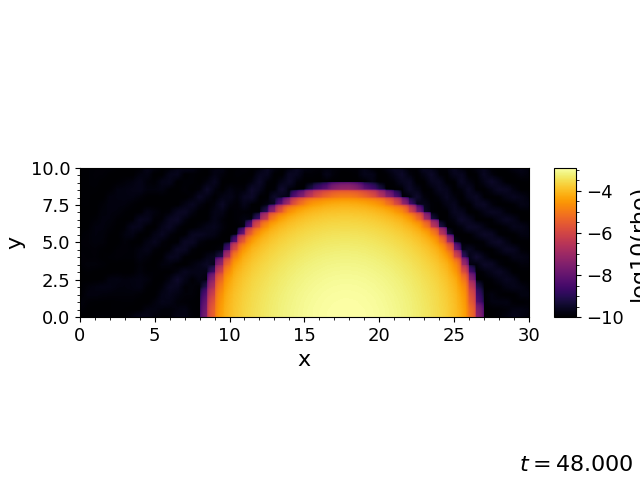

In [76]:
from IPython.display import Image

# datadir is the top-level directory that contains that data for
# a given simulation.
datadir = os.environ["HOME"]+"/simulations/headon_ET_short"
Image(filename=os.path.join(datadir, "rho_xy.png"))

In [67]:
%%bash
# Plot a 2D slice of the rest-mass density (which does not support reflection 
# symmetry, see below). 
#`-x0` and `-x1` define the region we want to plot: they coordinates of the 
# lower left and top right corners. 
#When not specified, the latest available iteration is plotted. 
./utils/Analysis/kuibit/examples/bins/plot_grid_var.py \
--datadir $HOME/simulations/headon_ET_short --variable "rho" -x0 0 0 -x1 30 10 \
--outdir  $HOME/simulations/headon_ET_short --logscale --multilinear-interpolate \
--colorbar --iteration 0 --figname "rho_t0_xy"

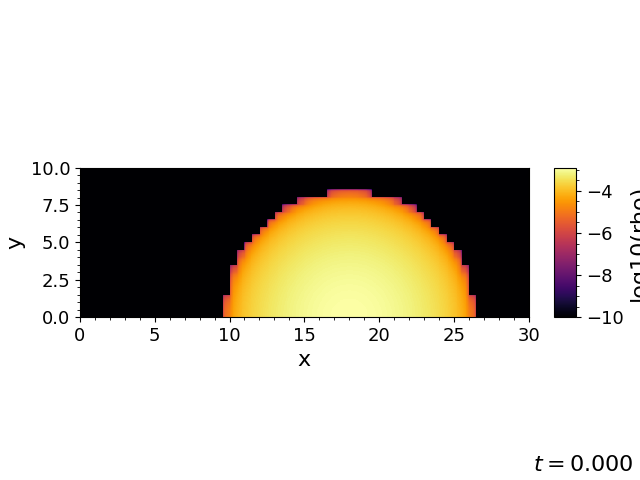

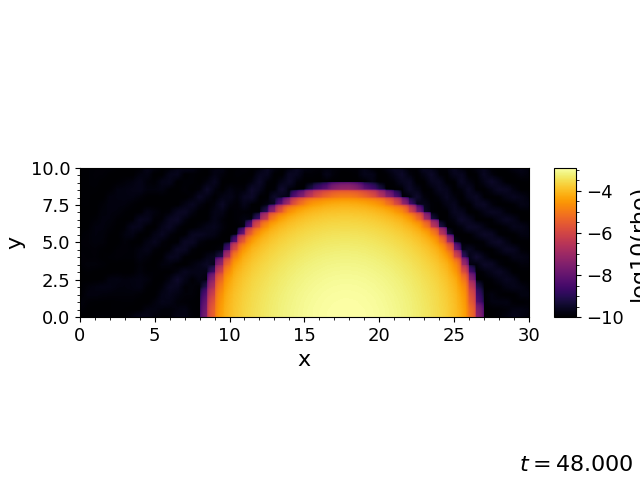

In [77]:
from IPython.display import Image

# datadir is the top-level directory that contains that data for
# a given simulation.
datadir = os.environ["HOME"]+"/simulations/headon_ET_short"
display(Image(filename=os.path.join(datadir, "rho_t0_xy.png")))
display(Image(filename=os.path.join(datadir, "rho_xy.png")))

In [82]:
!diff -u par/tov_ET.par par/headon_ET.par

--- par/tov_ET.par	2022-08-09 15:51:44.163186560 +0000
+++ par/headon_ET.par	2022-08-09 17:20:47.477414025 +0000
@@ -1,4 +1,4 @@
-# Example parameter file for a static TOV star. Everything is evolved, but
+# Example parameter file for a head-on collision. Everything is evolved, but
 # because this is a solution to the GR and hydro equations, nothing changes
 # much. What can be seen is the initial perturbation (due to numerical errors)
 # ringing down (look at the density maximum), and later numerical errors
@@ -35,21 +35,25 @@
 CoordBase::xmin =  0.0
 CoordBase::ymin =  0.0
 CoordBase::zmin =  0.0
-CoordBase::xmax = 24.0
+# CHANGE
+CoordBase::xmax = 48.0 # make longer
 CoordBase::ymax = 24.0
 CoordBase::zmax = 24.0
 # Change these parameters to change resolution. The ?max settings above
 # have to be multiples of these. 'dx' is the size of one cell in x-direction.
 # Making this smaller means using higher resolution, because more points will
 # be used to cover the same space.
-CoordB

CoM 17.669259192082936


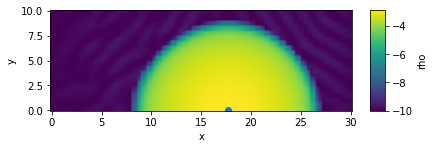

In [120]:
import numpy as np

sim = SimDir(os.environ["HOME"]+"/simulations/headon_ET_short")

iteration_number = sim.gridfunctions.xy["rho"].iterations[-1]
rho_xy = sim.gridfunctions.xy["rho"][iteration_number]

# We cannot plot rho_xy directly because it contains all
# the information for the various refinement levels. 
# We need to resample the data onto a uniform grid.

# shape is the resolution at which we resample
# x0, x1 are the bottom left and top right coordiantes
# that we want to consider

# Here we choose x0=[0,0] because we have reflection 
# symmetry

# resample=True activates multilinear resampling

rho_xy_unif = rho_xy.to_UniformGridData(shape=[100, 100], 
                                        x0=[0,0],
                                        x1=[30, 10],
                                        resample=True)

x = np.linspace(0., 30., 100)

# CoM
M = rho_xy_unif.data.sum()
# transpose due to Cactus vs. numpy 2d array memory layout
CoM = (rho_xy_unif.data.transpose() * x).sum()/M
print("CoM", CoM)

a = viz.plot_color(rho_xy_unif,
               logscale=True,
               colorbar=True,
               label="rho",
               xlabel="x",
               ylabel="y",
              )
# show CoM
plt.plot(CoM, 0., "o")

CoM 18.00029605822374


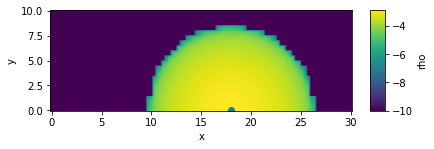

In [121]:
import numpy as np

sim = SimDir(os.environ["HOME"]+"/simulations/headon_ET_short")

iteration_number = 0
rho_xy = sim.gridfunctions.xy["rho"][iteration_number]

# We cannot plot rho_xy directly because it contains all
# the information for the various refinement levels. 
# We need to resample the data onto a uniform grid.

# shape is the resolution at which we resample
# x0, x1 are the bottom left and top right coordiantes
# that we want to consider

# Here we choose x0=[0,0] because we have reflection 
# symmetry

# resample=True activates multilinear resampling

rho_xy_unif = rho_xy.to_UniformGridData(shape=[100, 100], 
                                        x0=[0,0],
                                        x1=[30, 10],
                                        resample=True)

x = np.linspace(0., 30., 100)

# CoM
M = rho_xy_unif.data.sum()
# transpose due to Cactus vs. numpy 2d array memory layout
CoM = (rho_xy_unif.data.transpose() * x).sum()/M
print("CoM", CoM)

a = viz.plot_color(rho_xy_unif,
               logscale=True,
               colorbar=True,
               label="rho",
               xlabel="x",
               ylabel="y",
              )
# show CoM
plt.plot(CoM, 0., "o")